https://www.kaggle.com/sandipdatta/time-series-basic-analysis

**Objective** 

Basic Time Series Analysis

We will concentrate only on the Bitcoin price file from the input lot

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import numpy as np
import pandas as pd

# Input data files are available in the "../input/" directory.
from subprocess import check_output
print(check_output(["ls", "."]).decode("utf8"))

chp-data
cryptocurrency-historical-prices.ipynb
everything-you-can-do-with-a-time-series.ipynb
eycdwats-data
README.md
R-forecasting.md
R-timeSeries.md



In [2]:
# Import Packages
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
from pandas import DataFrame
import matplotlib.pyplot as plt

#importing packages for the prediction of time-series data
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.metrics import mean_squared_error

%matplotlib inline

In [3]:
df = pd.read_csv('chp-data//bitcoin_price.csv', parse_dates=['Date'])
df.head(3)

,Date,Open,High,Low,Close,Volume,Market Cap
0,2018-02-20,11231.8,11958.5,11231.8,11403.7,"9,926,540,000","189,536,000,000"
1,2018-02-19,10552.6,11273.8,10513.2,11225.3,"7,652,090,000","178,055,000,000"
2,2018-02-18,11123.4,11349.8,10326.0,10551.8,"8,744,010,000","187,663,000,000"


**Initial Inspections**

In [4]:
df.describe()

,Open,High,Low,Close
count,1760.000000,1760.000000,1760.000000,1760.000000
mean,1479.574239,1536.991108,1418.251273,1485.747000
std,2950.457188,3092.950362,2780.859459,2959.265478
min,68.500000,74.560000,65.530000,68.430000
25%,274.730000,279.857500,268.640000,274.875000
50%,480.715000,495.195000,472.510000,482.810000
75%,870.085000,900.222500,831.682500,871.370000
max,19475.800000,20089.000000,18974.100000,19497.400000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1760 entries, 0 to 1759
Data columns (total 7 columns):
Date          1760 non-null datetime64[ns]
Open          1760 non-null float64
High          1760 non-null float64
Low           1760 non-null float64
Close         1760 non-null float64
Volume        1760 non-null object
Market Cap    1760 non-null object
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 96.3+ KB


Lets segregate the Date & Close price to analyze them separately

In [6]:
df1 = df[['Date','Close']]
df1.head(3)

,Date,Close
0,2018-02-20,11403.7
1,2018-02-19,11225.3
2,2018-02-18,10551.8


In [7]:
# Setting the Date as Index
df_ts = df1.set_index('Date')
df_ts.sort_index(inplace=True)
df_ts.head(3)

,Close
Date,
2013-04-28,134.21
2013-04-29,144.54
2013-04-30,139.00


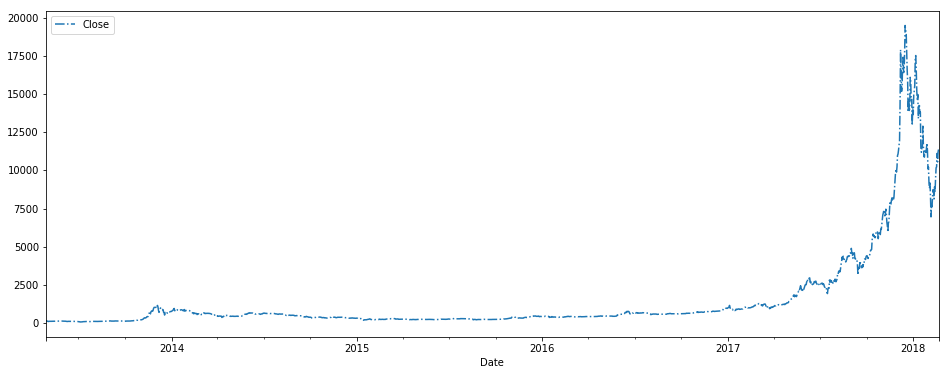

In [8]:
# Basic plot
ax = df_ts.plot(figsize=(16,6), linestyle="-.")
plt.show()

In [9]:
from statsmodels.tsa.stattools import adfuller

# Dickey Fuller Test Function
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    
    dftest = adfuller(timeseries, autolag='AIC')
    
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print(dfoutput)

In [10]:
# Stationarity Check - Lets do a quick check on Stationarity with Dickey Fuller Test 
# Convert the DF to series first
ts = df_ts['Close']
test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                   -1.360453
p-value                           0.601082
#lags Used                       25.000000
Number of Observations Used    1734.000000
Critical Value (1%)              -3.434127
Critical Value (5%)              -2.863208
Critical Value (10%)             -2.567658
dtype: float64


**Conclusion**

The Test Statistics value is Much higher than critical value. So we can't reject the Null Hypothesis.

Hence Statistically (and obviously from the plot) the Time series is Non-Stationary

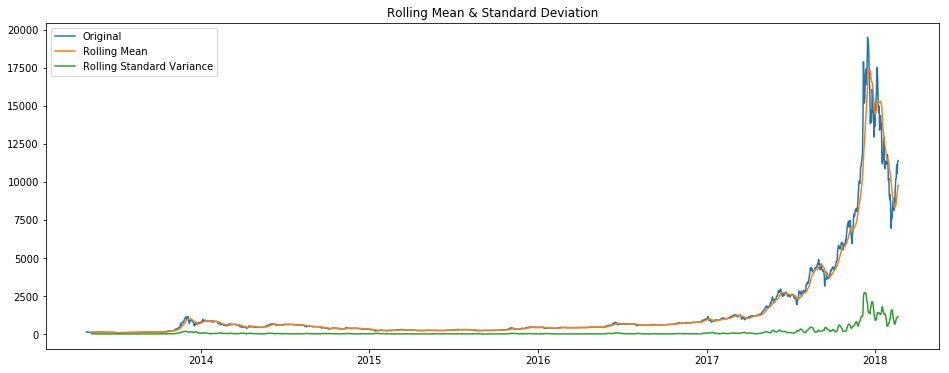

In [11]:
# Let's plot the 12-Month Moving Rolling Mean & Variance and find Insights
# Rolling Statistics
rolmean = ts.rolling(window=12).mean()
rolvar = ts.rolling(window=12).std()

plt.figure(figsize=(16,6))
plt.plot(ts, label='Original')
plt.plot(rolmean, label='Rolling Mean')
plt.plot(rolvar, label='Rolling Standard Variance')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

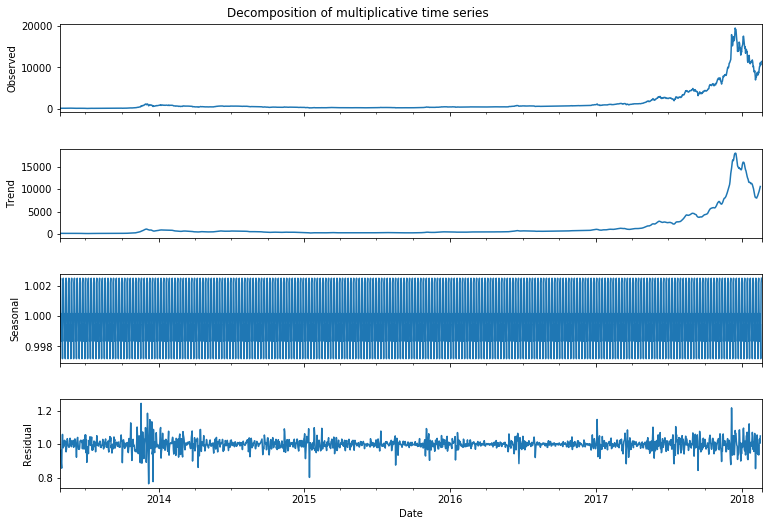

In [12]:
# Lets do a quick vanila decomposition to see any trend seasonality etc in the ts
decomposition = sm.tsa.seasonal_decompose(ts, model='multiplicative')

fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series')
plt.show()

**Conslusion**

Seasonal graph is too stacked - leaving us quite unequipped to sight anything specific. This was obvious by the way since we are analyzing daily data.

Let's try out a Monthly approach

In [13]:
# Lets Resample the data by Month and analyze again
df_ts_m = df_ts.resample('M').mean()
df_ts_m.head(3)

,Close
Date,
2013-04-30,139.250000
2013-05-31,119.993226
2013-06-30,107.761333


In [14]:
tsm = df_ts_m['Close']
tsm.head()

Date
2013-04-30    139.250000
2013-05-31    119.993226
2013-06-30    107.761333
2013-07-31     90.512258
2013-08-31    113.905161
Freq: M, Name: Close, dtype: float64

In [15]:
# Stationarity Check
test_stationarity(tsm)

Results of Dickey-Fuller Test:
Test Statistic                  2.126442
p-value                         0.998816
#lags Used                      6.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64


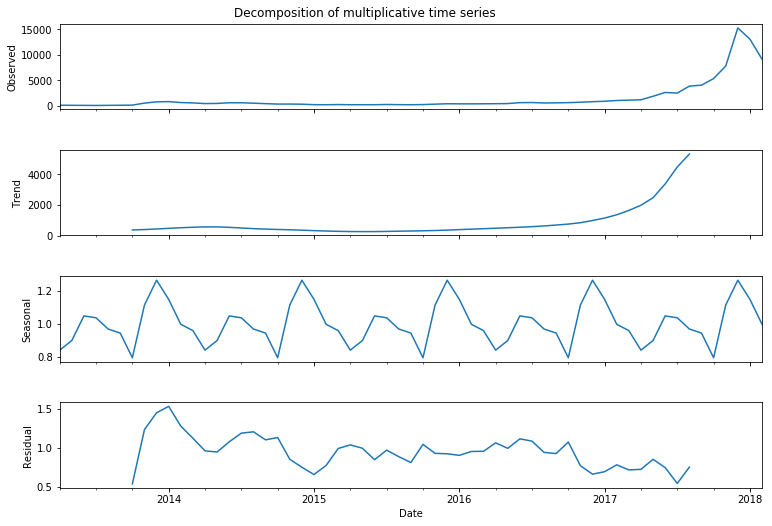

In [16]:
# Lets do a quick vanila decomposition to see any trend seasonality etc in the ts
decomposition = sm.tsa.seasonal_decompose(tsm, model='multiplicative')

fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series')
plt.show()

**Conclusion**

This we see a somewhat clarity on the Seasonality graph

In [17]:
# lets try to make the "tsm" Stationary
tsmlog = np.log10(tsm)
tsmlog.dropna(inplace=True)

tsmlogdiff = tsmlog.diff(periods=1)
tsmlogdiff.dropna(inplace=True)

# Stationarity Check
test_stationarity(tsmlogdiff)

Results of Dickey-Fuller Test:
Test Statistic                 -5.098131
p-value                         0.000014
#lags Used                      0.000000
Number of Observations Used    57.000000
Critical Value (1%)            -3.550670
Critical Value (5%)            -2.913766
Critical Value (10%)           -2.594624
dtype: float64


**Conclusion**

Now the Test Statistics is less than Critical value - rendering that The time series is Stationary now. 
We can use it now in Forecasting Techniques like ARIMA

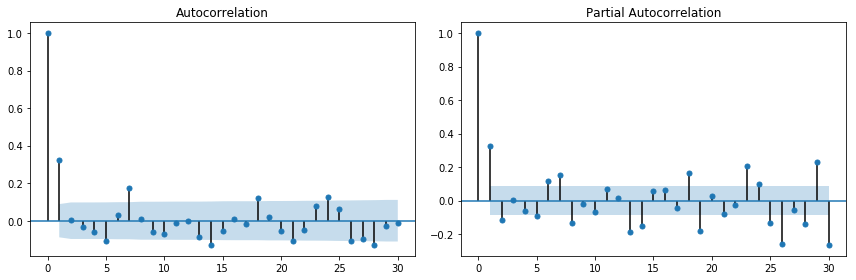

In [18]:
# Let's plot ACF & PACF graphs to visualize AR & MA components
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(tsmlogdiff, lags=30, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(tsmlogdiff, lags=30, ax=axes[1], alpha=0.5)
plt.tight_layout()